In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
import tqdm.notebook as tqdm
import numpy as np
from torch.utils import data as D
import os
import sys
dir_path = os.path.dirname(os.path.realpath('__file__'))
sys.path.append('/'.join(dir_path.split('/')[:-1]) + '/src/models')
import regression_2d
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

model = regression_2d.regression2d()
state_dict = torch.load('../trained_models/LL1_model.pt', map_location = torch.device('cpu'))
model.load_state_dict(state_dict['state_dict'])
device = torch.device('cuda:1')
model = model.to(device).eval()

esm_model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")
batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.eval().cuda(1)

Using cache found in /home/blai/.cache/torch/hub/facebookresearch_esm_main


In [19]:
file_paths = ['./seq_data/R2_seq.csv', './seq_data/R4_seq.csv', './seq_data/R5_seq.csv',
            './seq_data/R6_seq.csv', './seq_data/int_seq.csv', './seq_data/final_seq.csv'] 

score_at_R = dict()
for file_path in file_paths:
    R = file_path.split('/')[-1].split('_')[0]
    f = open(file_path, 'r').readlines()
    scores = []
    print(R)
    pbar = tqdm.tqdm(total = len(f[:1000]))
    for line in f[:1000]:
        pbar.update()        
        seq_A = line.split(',')[0]
        seq_B = line.split(',')[1]
        data = {
            ('A',seq_A),
            ('B',seq_B)
        }
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        with torch.no_grad():
            results = esm_model(batch_tokens.cuda(1), repr_layers=[33], return_contacts=True)
            token_representations = results["representations"][33]

        A_embedding = token_representations[0, 1:].mean(0).detach()
        B_embedding = token_representations[1, 1:].mean(0).detach()
        
        feat = torch.outer(A_embedding, B_embedding).unsqueeze(0).unsqueeze(1).cuda(1)
        pred = model(feat).item()
        scores.append(pred)
    score_at_R[R] = scores

R2


  0%|          | 0/1000 [00:00<?, ?it/s]

R4


  0%|          | 0/1000 [00:00<?, ?it/s]

R5


  0%|          | 0/1000 [00:00<?, ?it/s]

R6


  0%|          | 0/1000 [00:00<?, ?it/s]

int


  0%|          | 0/1000 [00:00<?, ?it/s]

final


  0%|          | 0/306 [00:00<?, ?it/s]

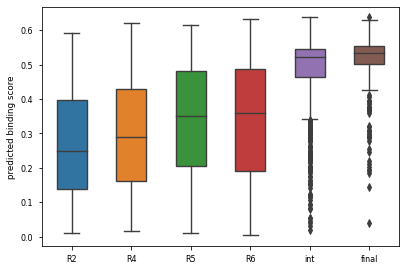

In [20]:
#print(score_at_R['int'])
sns.boxplot([score_at_R[r] for r in score_at_R], width = .5)
plt.xticks(range(len(score_at_R)), list(score_at_R.keys()))
plt.ylabel('predicted binding score')
plt.show()